In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms

In [7]:
import pathlib
datapath=pathlib.Path(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\data")

transform = transforms.Compose([transforms.Pad(2),transforms.ToTensor(),transforms.Normalize(mean=[127.5],std=[127.5])])

train_mnist = datasets.MNIST(str(datapath),train=True,download=True,transform=transform)
test_mnist = datasets.MNIST(str(datapath),train=False,download=True, transform=transform)

print(f"train mnist size : {len(train_mnist)}, test mnist size : {len(test_mnist)}")

train mnist size : 60000, test mnist size : 10000


In [29]:
import random
idx = random.choice(range(len(train_mnist)))
image,label = train_mnist[idx]
print(f"picked index : {idx}")
print(image.shape,label)
print(f"image min : {image.min()}, image max : {image.max()}")

picked index : 34320
torch.Size([1, 32, 32]) 8
image min : -1.0, image max : -0.9921568632125854


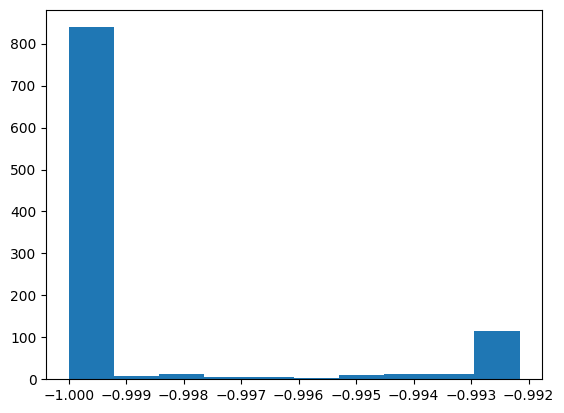

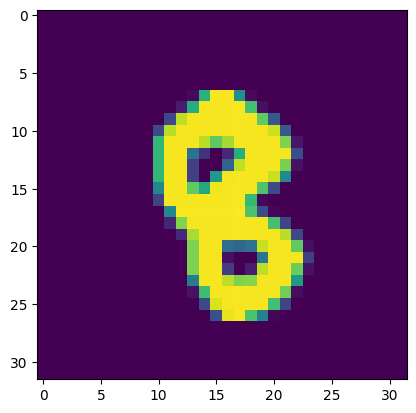

In [30]:
import matplotlib.pyplot as plt

plt.hist(image.flatten().numpy())
plt.figure()
plt.imshow(image.squeeze(0))

In [31]:

out1=nn.Conv2d(1,16,kernel_size=)

torch.Size([1, 32, 32])

In [32]:
def calc_out_height(height,kernel_size,stride,padding):
    return (height+2*padding-kernel_size)/stride+1

In [36]:
print(f"kernel 5, stride 2, padding 1 : {calc_out_height(32,5,2,1)}")
print(f"height 15, kernel 3, stride 2, padding 1 : {calc_out_height(15,3,2,1)}")
print(f"height 8, kernel 3, stride 2, padding 1 : {calc_out_height(8,3,2,1)}")
print(f"height 4, kernel 3, stride 2, padding 1 : {calc_out_height(4,3,2,1)}")


kernel 5, stride 2, padding 1 : 15.5
height 15, kernel 3, stride 2, padding 1 : 8.0
height 8, kernel 3, stride 2, padding 1 : 4.5
height 4, kernel 3, stride 2, padding 1 : 2.5


In [37]:
def swish(x,beta=1.0):
    return x * F.sigmoid(beta*x)

In [40]:
ret=swish(image.flatten().squeeze(0))

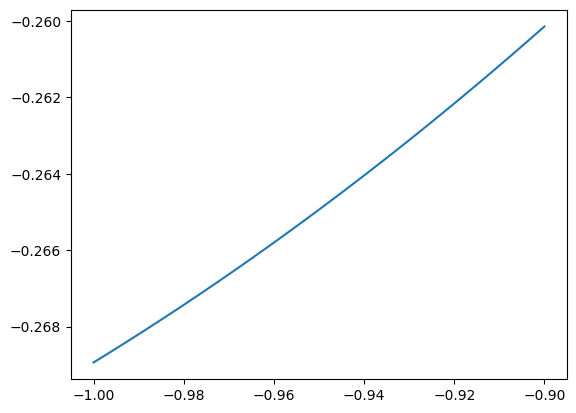

In [51]:
x=torch.linspace(-1,-0.9,steps=100)
y=swish(x)
plt.plot(x,y)

In [57]:
images = torch.normal(0,1,(100,1,32,32))
flat_images = images.flatten(start_dim=1)
print(f"images shape : {images.shape}, flat_images shape : {flat_images.shape}")

images shape : torch.Size([100, 1, 32, 32]), flat_images shape : torch.Size([100, 1024])


In [58]:
class EnergyFunction(nn.Module):
    def __init__(self,out_size=2, out_channels=64) -> None:
        super(EnergyFunction,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=1)
        self.conv2=nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.dense = nn.Linear(out_size*out_size*out_channels,64)
        self.dense2 = nn.Linear(64,1)
    
    def forward(self,x):
        x = swish(self.conv1(x))
        x = swish(self.conv2(x))
        x = swish(self.conv3(x))
        x = swish(self.conv4(x))
        x = x.flatten(start_dim=1)
        x = swish(self.dense(x))
        return self.dense2(x)


In [59]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_mnist,batch_size=64, shuffle=True)



In [163]:
idx = random.choice(range(len(train_loader)))
print(f"picked idx {idx} from {len(train_loader)} batches")
for idx,(images,labels) in enumerate(train_loader):
    if idx == idx:
        break

picked idx 331 from 938 batches


In [62]:
model = EnergyFunction()

In [64]:
out = model(images)
print(f"out shape : {out.shape}")
print(f"its mean is : {torch.mean(out,dim=0)}")

out shape : torch.Size([64, 1])
its mean is : tensor([0.0407], grad_fn=<MeanBackward1>)


In [65]:
images1 = torch.rand(64,1,32,32)
images2 = torch.rand(64,1,32,32)
images = torch.cat([images1,images2],dim=0)
print(f"images shape : {images.shape}")

images shape : torch.Size([128, 1, 32, 32])


In [66]:
out = model(images)
out1,out2 = torch.split(out,out.size(0)//2)
print(f"out1 shape : {out1.shape}, out2 shape : {out2.shape}")

out1 shape : torch.Size([64, 1]), out2 shape : torch.Size([64, 1])


In [199]:
GRAD_CLIP = 0.03

def generate_samples(model, inp_images, steps, step_size, noise, return_imgs_per_step=False):
    imgs_per_step = []     

    for _ in range(steps):
        inp_images = inp_images.detach()
        inp_images.requires_grad_(True)
        noised_inp_images = inp_images + torch.normal(0, noise, size = inp_images.size())
        noised_inp_images = torch.clamp(noised_inp_images, -1.0, 1.0)               

        model.zero_grad()
        outscore = model(noised_inp_images)
        mean_outscore = torch.mean(outscore,dim=0)
        mean_outscore.backward()
        grads = torch.clamp(inp_images.grad,-1*GRAD_CLIP,GRAD_CLIP)
        inp_images = inp_images + step_size * grads
        inp_images = torch.clamp(inp_images, -1.0, 1.0)

        if return_imgs_per_step:
            imgs_per_step.append(inp_images)
    if return_imgs_per_step:
        return torch.stack(imgs_per_step,dim=0)
    return inp_images

In [200]:
steps=60
step_size = 10
noise = 0.005

out_images = generate_samples(model,images,steps,step_size,noise)

In [194]:
out_images.shape

torch.Size([64, 1, 32, 32])

In [181]:
inp_images = images
print(inp_images.requires_grad)

True


In [89]:
step_size = 10
noise = 0.005

In [177]:
inp_images.requires_grad=True


In [191]:
inp_images = inp_images.detach()
inp_images.requires_grad_(True)
noised_inp_images = inp_images + torch.normal(0, noise, size = inp_images.size())
noised_inp_images = torch.clamp(noised_inp_images, -1.0, 1.0)


#model.zero_grad()
outscore = model(noised_inp_images)
mean_outscore = torch.mean(outscore,dim=0)
mean_outscore.backward()
grads = torch.clamp(inp_images.grad,-1*GRAD_CLIP,GRAD_CLIP)
inp_images = inp_images + step_size * grads
inp_images = torch.clamp(inp_images, -1.0, 1.0)


In [185]:
inp_images.grad

C:\Users\amrul\AppData\Local\Temp\ipykernel_19404\793545918.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  inp_images.grad


In [124]:
grads

tensor([[[[ 2.9716e-08, -8.7822e-08, -2.3152e-07,  ..., -6.1674e-08,
           -4.4773e-08, -7.2686e-08],
          [ 5.4947e-08, -2.5522e-07,  3.1806e-07,  ..., -5.5170e-07,
           -2.2609e-07,  1.5435e-07],
          [ 1.5649e-07,  1.0640e-07,  2.5687e-07,  ..., -3.4238e-08,
            1.0701e-07,  4.6808e-07],
          ...,
          [-1.2338e-07,  1.1494e-07, -3.8582e-08,  ...,  9.4501e-08,
            1.0504e-07,  3.7644e-08],
          [ 4.9410e-08,  1.9696e-07,  9.5610e-08,  ..., -5.7042e-08,
           -3.2062e-08,  1.2183e-07],
          [ 1.1788e-07,  1.5705e-07, -5.0182e-08,  ..., -9.7266e-08,
            1.0734e-08, -4.3892e-08]]],


        [[[ 2.9750e-08, -8.7236e-08, -2.3158e-07,  ..., -6.0184e-08,
           -4.4615e-08, -7.3073e-08],
          [ 5.4792e-08, -2.5624e-07,  3.1550e-07,  ..., -5.5004e-07,
           -2.2586e-07,  1.5366e-07],
          [ 1.5690e-07,  1.0571e-07,  2.5749e-07,  ..., -3.1915e-08,
            1.0525e-07,  4.6845e-07],
          ...,
   

In [ ]:
inp_images = generate_samples(model,images,60,10,0.005)